In [1]:
#!pip install git+https://github.com/moment-timeseries-foundation-model/moment.git #--no-deps

In [2]:
from momentfm.data.anomaly_detection_dataset import AnomalyDetectionDataset

test_dataset = AnomalyDetectionDataset(data_split='test', random_seed=13)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/transformers/utils/generic.py:311: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  torch.utils._pytree._register_pytree_node(


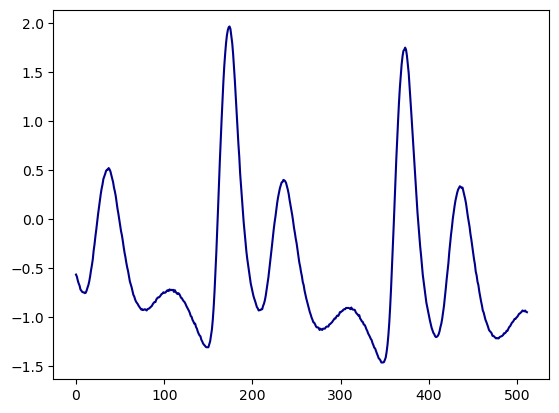

In [3]:
import numpy as np
import matplotlib.pyplot as plt

idx = np.random.randint(0, len(test_dataset))
plt.plot(test_dataset[idx][0].squeeze(), c='darkblue')
plt.show()

In [4]:
from torch.utils.data import DataLoader

test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=False, drop_last=False)

In [5]:
from dvats import utils as ut

In [6]:
timer = ut.Time()
timer.start()

1727104088.2741597

In [7]:
from momentfm import MOMENTPipeline

model = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large", 
    model_kwargs={
        "task_name": "forecasting",
        'forecast_horizon': 192,
        'head_dropout' : 0.1,
        'weight_decay': 0,
        'freeze_encoder': True,
        'freeze_embedder': True,
        'freeze_head': False,
    },
    # local_files_only = True,
)

In [8]:
model.init()

In [9]:
timer.end()
timer.duration

<bound method Time.duration of Time(time_start=1727104088.2741597, time_end=1727104095.261138, time_total=6.98697829246521, function='')>

In [10]:
print("Unfrozen parameters:")
for name, param in model.named_parameters():    
    if param.requires_grad:
        print('    ', name)

Unfrozen parameters:
     head.linear.weight
     head.linear.bias


In [11]:
from pprint import pprint
import torch

# takes in tensor of shape [batchsize, n_channels, context_length]
x = torch.randn(16, 1, 512) #512 timesteps
output = model(x)
pprint(output)

/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/_dynamo/eval_frame.py:600: UserWarning: torch.utils.checkpoint: the use_reentrant parameter should be passed explicitly. In version 2.4 we will raise an exception if use_reentrant is not passed. use_reentrant=False is recommended, but if you need to preserve the current default behavior, you can pass use_reentrant=True. Refer to docs for more details on the differences between the two variants.
  return fn(*args, **kwargs)
/usr/local/share/miniconda3/envs/env/lib/python3.10/site-packages/torch/utils/checkpoint.py:92: UserWarning: None of the inputs have requires_grad=True. Gradients will be None
  warnings.warn(


TimeseriesOutputs(forecast=tensor([[[ 0.1043,  0.0808,  0.0854,  ...,  0.0174,  0.1301,  0.0269]],

        [[-0.0015,  0.0722, -0.0150,  ..., -0.0333, -0.0015, -0.0015]],

        [[ 0.1132, -0.0400,  0.0100,  ...,  0.0058,  0.0533, -0.0106]],

        ...,

        [[-0.0501,  0.0592, -0.0453,  ...,  0.0046, -0.0531, -0.1889]],

        [[ 0.0683,  0.1049,  0.0407,  ..., -0.0311,  0.0896, -0.0075]],

        [[ 0.0517,  0.0803,  0.0517,  ...,  0.0225,  0.0963,  0.0517]]],
       grad_fn=<AddBackward0>),
                  anomaly_scores=None,
                  logits=None,
                  labels=None,
                  input_mask=tensor([[1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        ...,
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.],
        [1., 1., 1.,  ..., 1., 1., 1.]]),
                  pretrain_mask=None,
                  reconstruction=None,
                  embedding

In [12]:
output.forecast.shape #batch x channels x window length

torch.Size([16, 1, 192])

Little training

MOMENT is pre-trained using a reconstruction head and a reconstruction head. To use MOMENT for forecasting, we replace the reconstruction head to a forecasting head. The forecasting head is a randomly initilized linear layer which maps MOMENT's embeddings to the forecasting horizon.

The forecasting head is randomly initialized, so it must be trained on your data.

In [13]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

In [14]:
! cp ~/data/ETTh1.csv ../data/ETTh1.csv

Para poder ejecutar el InformerDataset he tenido que modifiicar la linea cd ~/.local/lib/python3.10/site-packages/momentfm/informer_dataset.py 67 para que no use copy = False

In [15]:
# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

In [16]:
test_dataset = InformerDataset(data_split="test", random_seed=4, forecast_horizon=192)

In [17]:
test_dataset.__len__()

-703

In [18]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

ValueError: __len__() should return >= 0

In [ ]:
len( train_loader.dataset)

In [ ]:
? test_dataset.__len__

In [ ]:
test_dataset.__len__()

In [ ]:
# No entiendo qué le pasa
#test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)
test_loader = train_loader

In [ ]:
import torch
from tqdm import tqdm

model = model.to("cuda").float()

trues, preds, labels = [], [], []
with torch.no_grad():
    for batch_x, batch_masks, batch_labels in tqdm(test_dataloader, total=len(test_dataloader)):
        batch_x = batch_x.to("cuda").float()
        batch_masks = batch_masks.to("cuda")

        output = model(batch_x, input_mask=batch_masks) # [batch_size, n_channels, window_size]

        trues.append(batch_x.detach().squeeze().cpu().numpy())
        preds.append(output.reconstruction.detach().squeeze().cpu().numpy())
        labels.append(batch_labels.detach().cpu().numpy())

In [ ]:
? output.embeddings

In [ ]:
import numpy as np

trues = np.concatenate(trues, axis=0).flatten()
preds = np.concatenate(preds, axis=0).flatten()
labels = np.concatenate(labels, axis=0).flatten()

# The last and the second to last windows have overlapping timesteps. We will remove these overlapping predictions
n_unique_timesteps = 512 - trues.shape[0] + test_dataset.length_timeseries
trues = np.concatenate([trues[:512*(test_dataset.length_timeseries//512)], trues[-n_unique_timesteps:]])
preds = np.concatenate([preds[:512*(test_dataset.length_timeseries//512)], preds[-n_unique_timesteps:]])
labels = np.concatenate([labels[:512*(test_dataset.length_timeseries//512)], labels[-n_unique_timesteps:]])
assert trues.shape[0] == test_dataset.length_timeseries

# We will use the Mean Squared Error (MSE) between the observed values and MOMENT's predictions as the anomaly score
anomaly_scores = (trues - preds)**2

In [ ]:
from momentfm.utils.anomaly_detection_metrics import adjbestf1

print(f"Zero-shot Adjusted Best F1 Score: {adjbestf1(y_true=labels, y_scores=anomaly_scores)}") 

In [ ]:
anomaly_start = 74158
anomaly_end = 74984
start = anomaly_start-512
end = anomaly_end+512

plt.plot(trues[start:end], label="Observed", c='darkblue')
plt.plot(preds[start:end], label="Predicted", c='red')
plt.plot(anomaly_scores[start:end], label="Anomaly Score", c='black')
plt.legend(fontsize=16)
plt.show()

In [ ]:
test_dataloader.dataset

In [ ]:
test_dataloader.dataset[0][0].shape
len (test_dataloader.dataset[0])

In [ ]:
len(test_dataloader.dataset)

In [ ]:
#dataset = np.array(test_dataloader.dataset)

In [ ]:
#dataset.shape

In [ ]:
inputs = []
for i in range (len(test_dataloader.dataset)):
    inputs.append(test_dataloader.dataset[i][0])

In [ ]:
enc_input = torch.from_numpy(np.array(inputs))

In [ ]:
enc_input.shape

In [ ]:
enc_input.to("cpu")
for i in range (len(test_dataloader.dataset)):
    enc_input[i].to("cpu").float()

In [ ]:
model.to("cpu")

In [ ]:
? enc_input

In [ ]:
enc_input.double()

In [ ]:
? enc_input

In [ ]:
? model 

In [ ]:
model.embed(  
    x_enc       = enc_input.float(), 
    input_mask  = None,
    reduction   = "mean"
)

In [ ]:
model.DataEmbedding

In [ ]:
embs = get_enc_embs(
    X          = test_dataloader.dataset, 
    enc_learn  = model, 
    cpu        = 'False', 
    to_numpy   = True,
    batch_size = enc_run.config['batch_size'],
    verbose    = 1
)

In [ ]:
from momentfm import MOMENTPipeline

In [ ]:
embmodel = MOMENTPipeline.from_pretrained(
    "AutonLab/MOMENT-1-large",
    model_kwargs = {"task_name": "embedding"},
)
model.init()

In [ ]:
? embmodel

In [ ]:
import numpy as np
import torch
import torch.cuda.amp
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

from momentfm.utils.utils import control_randomness
from momentfm.data.informer_dataset import InformerDataset
from momentfm.utils.forecasting_metrics import get_forecasting_metrics

# Set random seeds for PyTorch, Numpy etc.
control_randomness(seed=13) 

# Load data
train_dataset = InformerDataset(data_split="train", random_seed=13, forecast_horizon=192)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

test_dataset = InformerDataset(data_split="test", random_seed=13, forecast_horizon=192)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

cur_epoch = 0
max_epoch = 1

# Move the model to the GPU
model = model.to(device)

# Move the loss function to the GPU
criterion = criterion.to(device)

# Enable mixed precision training
scaler = torch.cuda.amp.GradScaler()

# Create a OneCycleLR scheduler
max_lr = 1e-4
total_steps = len(train_loader) * max_epoch
scheduler = OneCycleLR(optimizer, max_lr=max_lr, total_steps=total_steps, pct_start=0.3)

# Gradient clipping value
max_norm = 5.0

while cur_epoch < max_epoch:
    losses = []
    for timeseries, forecast, input_mask in tqdm(train_loader, total=len(train_loader)):
        # Move the data to the GPU
        timeseries = timeseries.float().to(device)
        input_mask = input_mask.to(device)
        forecast = forecast.float().to(device)

        with torch.cuda.amp.autocast():
            output = model(timeseries, input_mask)
        
        loss = criterion(output.forecast, forecast)

        # Scales the loss for mixed precision training
        scaler.scale(loss).backward()

        # Clip gradients
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)

        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad(set_to_none=True)

        losses.append(loss.item())

    losses = np.array(losses)
    average_loss = np.average(losses)
    print(f"Epoch {cur_epoch}: Train loss: {average_loss:.3f}")

    # Step the learning rate scheduler
    scheduler.step()
    cur_epoch += 1
    
    # Evaluate the model on the test split
    trues, preds, histories, losses = [], [], [], []
    model.eval()
    with torch.no_grad():
        for timeseries, forecast, input_mask in tqdm(test_loader, total=len(test_loader)):
        # Move the data to the GPU
            timeseries = timeseries.float().to(device)
            input_mask = input_mask.to(device)
            forecast = forecast.float().to(device)

            with torch.cuda.amp.autocast():
                output = model(timeseries, input_mask)
            
            loss = criterion(output.forecast, forecast)                
            losses.append(loss.item())

            trues.append(forecast.detach().cpu().numpy())
            preds.append(output.forecast.detach().cpu().numpy())
            histories.append(timeseries.detach().cpu().numpy())
    
    losses = np.array(losses)
    average_loss = np.average(losses)
    model.train()

    trues = np.concatenate(trues, axis=0)
    preds = np.concatenate(preds, axis=0)
    histories = np.concatenate(histories, axis=0)
    
    metrics = get_forecasting_metrics(y=trues, y_hat=preds, reduction='mean')

    print(f"Epoch {cur_epoch}: Test MSE: {metrics.mse:.3f} | Test MAE: {metrics.mae:.3f}")

In [ ]:
import matplotlib.pyplot as plt

# Assuming histories, trues, and preds are your lists containing the data
# Extracting the first data point

channel_idx = np.random.randint(0, 7) # There are 7 channels in this dataset
time_index = np.random.randint(0, trues.shape[0]) 

history = histories[time_index, channel_idx, :] 
true = trues[time_index, channel_idx, :]
pred = preds[time_index, channel_idx, :]

plt.figure(figsize=(12, 4))

# Plotting the first time series from history
plt.plot(range(len(history)), history, label='History (512 timesteps)', c='darkblue')

# Plotting ground truth and prediction
num_forecasts = len(true)

offset = len(history)
plt.plot(range(offset, offset + len(true)), true, label='Ground Truth (192 timesteps)', color='darkblue', linestyle='--', alpha=0.5)
plt.plot(range(offset, offset + len(pred)), pred, label='Forecast (192 timesteps)', color='red', linestyle='--')

plt.title(f"ETTh1 (Hourly) -- (idx={time_index}, channel={channel_idx})", fontsize=18)
plt.xlabel('Time', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.legend(fontsize=14)
plt.show()